In [1]:
import os

# below must be done before importing numpy
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

import shutil
from multiprocessing import Pool
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import pymc3 as pm
import theano.tensor as tt
import theano

import sys

sys.path.insert(0, "../htf_projections/")
from support_functions import station_string
from tide_gauge_data import tide_gauge_data

from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial"]

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
logging.getLogger().setLevel(logging.CRITICAL)

In [2]:
%matplotlib widget

In [3]:
fname = "../data/stations.pickle"
stations = pd.read_pickle(fname)
stations

,id,name,state,scn_name,tool_name,lat,lon
0,8665530,"Charleston, Cooper River Entrance",SC,"Charleston, SC","Charleston, SC",32.780833,-79.923611
1,9418767,North Spit,CA,"Humboldt Bay, CA","Humboldt Bay, CA",40.766300,-124.217200
2,8575512,Annapolis,MD,"Annapolis, MD","Annapolis, MD",38.983280,-76.481600
3,9443090,Neah Bay,WA,"Neah Bay, WA","Neah Bay, WA",48.370278,-124.601944
4,9444900,Port Townsend,WA,"Port Townsend, WA","Port Townsend, WA",48.112900,-122.759500
...,...,...,...,...,...,...,...
115,9432780,Charleston,OR,"Charleston, OR","Charleston, OR",43.345000,-124.322000
116,1612480,Mokuoloe,HI,"Mokuoloe, HI","Mokuoloe, HI",21.433056,-157.790000
117,8651370,Duck,NC,"Duck, NC","Duck, NC",36.183306,-75.746694
118,8632200,Kiptopeke,VA,"Kiptopeke, VA","Kiptopeke, VA",37.165190,-75.988444


In [7]:
# only do select stations
select = ["9461380"]
keep = [n for n in stations.index if stations.loc[n, "id"] in select]
keep

stations = stations.loc[keep]

for idx, sta in stations.iterrows():
    break

sta

id                     8770570
name         Sabine Pass North
state                       TX
scn_name       Sabine Pass, TX
tool_name      Sabine Pass, TX
lat                    29.7284
lon                   -93.8701
Name: 119, dtype: object

In [8]:
tg = tide_gauge_data(sta)

# remove trend and annual cycle
tg.res -= tg.trnd + tg.acyc

# -----------------------------------------------------------------------

# drop years which have more than 75% hours missing data
tg = tg.groupby(pd.Grouper(freq="A")).apply(
    lambda x: None if x.res.dropna().count() < 0.75 * 24 * 365 else x
)
try:
    tg.index = tg.index.droplevel(0)
except:
    pass

# drop months which have more than 10 days missing data
tg = tg.groupby(pd.Grouper(freq="M")).apply(
    lambda x: None if x.res.dropna().count() < 24 * 10 else x
)
try:
    tg.index = tg.index.droplevel(0)
except:
    pass

# -----------------------------------------------------------------------

ha = tg.res.dropna()

# -----------------------------------------------------------------------

amn = ha.groupby(pd.Grouper(freq="A")).mean()
amn.dropna(inplace=True)
amn_t = amn.index.year + 0.5

amn = amn.values
amn_t = amn_t.values

amn_mn = amn.mean()
amn_sd = amn.std()
amn_nrm = (amn - amn_mn) / amn_sd

amn_t_pred = np.arange(1890, 2110, 1) + 0.5

amn_t_nrm = (amn_t - 1900) / 100
amn_t_pred_nrm = ((amn_t_pred - 1900) / 100)[:, None]

# -----------------------------------------------------------------------

momn = ha.groupby(pd.Grouper(freq="M")).mean()
momn.dropna(inplace=True)
momn_t = momn.index.year + momn.index.month / 12 - 1 / 24

momn = momn.values
momn_t = momn_t.values

amni = np.interp(momn_t, amn_t, amn)
momn -= amni

# fit monthly gp to lastN months
lastN = 240

momn_mn = momn[-lastN:].mean()
momn_sd = momn[-lastN:].std()
momn_nrm = (momn - momn_mn) / momn_sd

momn_t_pred = np.arange(2000, 2101, 1 / 12) + 1 / 24

momn_t_nrm = (momn_t - 1900) / 100
momn_t_pred_nrm = ((momn_t_pred - 1900) / 100)[:, None]

momn_nrm = momn_nrm[-lastN:]
momn_t_nrm = momn_t_nrm[-lastN:]

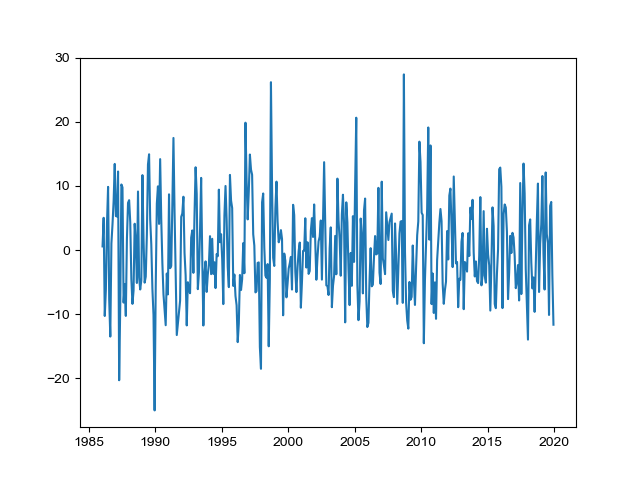

In [9]:
plt.figure()
plt.plot(momn_t, momn)

In [ ]:
draws = 500
chains = 2
cores = 1 # if mode == "series" else 1
tune = 2000
target_accept = 0.95
pbar = True # if mode == "series" else False

posterior_samples = 100

In [ ]:
# check priors
with pm.Model() as mo_model:

    # two random numbers that sum to one; used for variances of gp components;
    # they sum to one because data normalized to have std=1
    A2 = pm.Dirichlet("A2", a=np.array([1, 1]))

    L0 = pm.Gamma("L0", alpha=2, beta=2000)

    mo_trace = pm.sample(
        draws,
        chains=chains,
        cores=cores,
        tune=tune,
        target_accept=target_accept,
        progressbar=pbar,
    )


In [ ]:
pm.plots.plot_trace(mo_trace)

In [ ]:
with pm.Model() as mo_model:

    # two random numbers that sum to one; used for variances of gp components;
    # they sum to one because data normalized to have std=1
    A2 = pm.Dirichlet("A2", a=np.array([1, 1]))

    L0 = pm.Gamma("L0", alpha=2, beta=2000)
    cov0 = A2[0] * pm.gp.cov.ExpQuad(1, L0)
    gp = pm.gp.Marginal(cov_func=cov0)

    momn_ = gp.marginal_likelihood(
        "momn_", X=momn_t_nrm[:, None], y=momn_nrm, noise=tt.sqrt(A2[1])
    )

    mo_trace = pm.sample(
        draws,
        chains=chains,
        cores=cores,
        tune=tune,
        target_accept=target_accept,
        progressbar=pbar,
    )

In [ ]:
pm.plots.plot_trace(mo_trace)

In [ ]:
momn_pred = gp.conditional("momn_pred", momn_t_pred_nrm, pred_noise=True)

pbar = True if mode == "series" else False
momn_smpls = pm.sample_posterior_predictive(
    mo_trace,
    samples=posterior_samples,
    vars=[momn_pred],
    progressbar=pbar,
)

momn_smpls = momn_smpls["momn_pred"].T